# Generate Bat Outcome
 - Given the batter has made contact on the given pitch characteristics, what is the batting outcome?
 - I.e., what is the launch_speed_angle, and what is the hit_location

## Potential Difficulties:
 - How to factor in bunting?

In [23]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features as f
from src.data import data_utils as du
from importlib import reload
reload(f)

vladdy = 665489
soto = 665742
schneider = 676914
biggio = 624415
batter = soto
X_train, y_train, X_test, y_test, encoders = f.get_hit_outcome_dataset(batter, split=True)

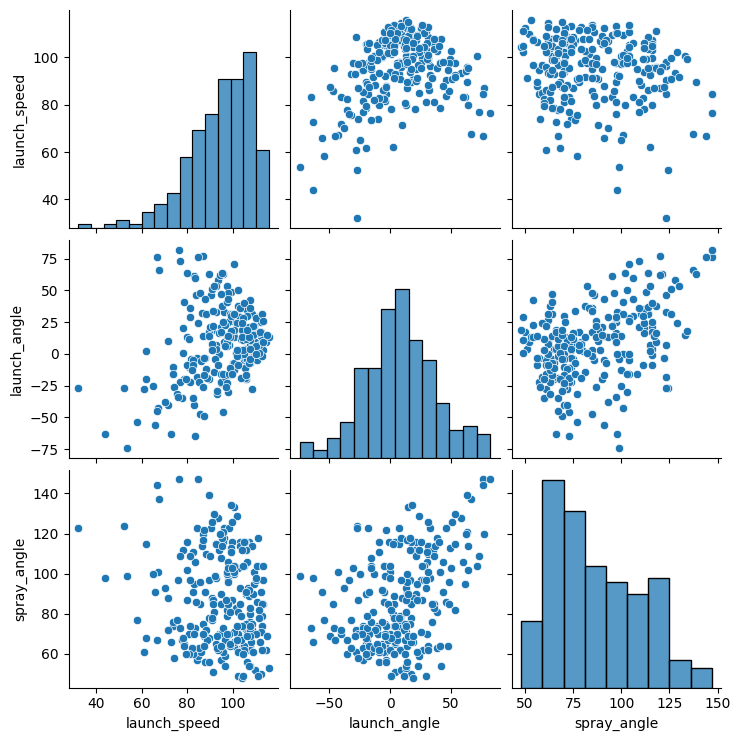

In [24]:
sns.pairplot(y_test)
plt.show()

In [42]:
import numpy as np
import scipy.stats as stats
from scipy.stats import kstest

def best_fit_distribution(data, distributions):
    best_distribution = None
    best_params = None
    p_val = None
    best_ks_stat = np.inf
    
    for distribution in distributions:
        # Fit the distribution to the data
        params = distribution.fit(data)
        
        # Generate a CDF from the fitted distribution
        cdf = lambda x: distribution.cdf(x, *params)
        
        # Perform the K-S test
        ks_stat, p_value = kstest(data, cdf)
        
        # Compare against the best so far
        if ks_stat < best_ks_stat:
            best_distribution = distribution
            best_params = params
            best_ks_stat = ks_stat
            p_val = p_value
    
    return best_distribution, best_params, best_ks_stat, p_val

def find_best_fits(data1, data2, data3):
    # Define candidate distributions for each dataset
    distributions_1 = [stats.lognorm, stats.gamma, stats.beta, stats.fatiguelife]
    distributions_2 = [stats.norm, ]
    distributions_3 = [stats.genpareto, stats.weibull_min, stats.weibull_max, stats.fatiguelife]
    
    # Find the best fit for each dataset
    best_dist_1, params_1, ks_1, p_val = best_fit_distribution(data1, distributions_1)
    best_dist_2, params_2, ks_2, p_val = best_fit_distribution(data2, distributions_2)
    best_dist_3, params_3, ks_3, p_val = best_fit_distribution(data3, distributions_3)
    
    return {
        'Variable 1': {'distribution': best_dist_1, 'params': params_1, 'ks_stat': ks_1, 'p_val': p_val},
        'Variable 2': {'distribution': best_dist_2, 'params': params_2, 'ks_stat': ks_2, 'p_val': p_val},
        'Variable 3': {'distribution': best_dist_3, 'params': params_3, 'ks_stat': ks_3, 'p_val': p_val}
    }

# Example usage with your data
#data1 = np.random.lognormal(mean=0, sigma=1, size=1000)
#data2 = np.random.normal(loc=0, scale=1, size=1000)
#data3 = np.random.weibull(a=2, size=1000)

input_data = []
for col in y_test.columns:
    input_data.append(y_test[col]) 

#best_fits = find_best_fits(data1, data2, data3)
best_fits = find_best_fits(*input_data)
print(best_fits)


{'Variable 1': {'distribution': <scipy.stats._continuous_distns.beta_gen object at 0x7a03c0945190>, 'params': (20.984172159517094, 2.141083962123707, -121.28449493895404, 237.65463344204665), 'ks_stat': 0.02094944984117464, 'p_val': 0.14409405794160013}, 'Variable 2': {'distribution': <scipy.stats._continuous_distns.norm_gen object at 0x7a03c0922f00>, 'params': (8.168776371308017, 29.154415675074908), 'ks_stat': 0.039206294562323274, 'p_val': 0.14409405794160013}, 'Variable 3': {'distribution': <scipy.stats._continuous_distns.weibull_min_gen object at 0x7a03c0947110>, 'params': (1.7768781547944488, 46.551910947185746, 44.63403070655609), 'ks_stat': 0.07377873046692718, 'p_val': 0.14409405794160013}}


In [38]:
best_fits['Variable 1']

{'distribution': <scipy.stats._continuous_distns.beta_gen at 0x7a03c0945190>,
 'params': (20.984172159517094,
  2.141083962123707,
  -121.28449493895404,
  237.65463344204665),
 'ks_stat': 0.02094944984117464}

In [41]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def plot_best_fit(data, distribution, params, title):
    # Create histogram of data
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')
    
    # Generate PDF from the best-fitting distribution
    x = np.linspace(min(data), max(data), 1000)
    pdf = distribution.pdf(x, *params[:-2], loc=params[-2], scale=params[-1])
    
    # Plot the PDF
    plt.plot(x, pdf, 'r-', lw=2, label='Best fit PDF')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.show()

def find_and_plot_best_fits(data1, data2, data3):
    # Define candidate distributions for each dataset
    distributions_1 = [stats.lognorm, stats.gamma, stats.beta, stats.fatiguelife]
    distributions_2 = [stats.norm]
    distributions_3 = [stats.genpareto, stats.weibull_min, stats.weibull_max, stats.fatiguelife]
    
    # Find the best fit for each dataset
    best_dist_1, params_1, ks_1 = best_fit_distribution(data1, distributions_1)
    best_dist_2, params_2, ks_2 = best_fit_distribution(data2, distributions_2)
    best_dist_3, params_3, ks_3 = best_fit_distribution(data3, distributions_3)
    
    # Plot the best-fitting distributions
    plot_best_fit(data1, best_dist_1, params_1, 'Best fit for Variable 1')
    plot_best_fit(data2, best_dist_2, params_2, 'Best fit for Variable 2')
    plot_best_fit(data3, best_dist_3, params_3, 'Best fit for Variable 3')

input_data = []
for col in y_test.columns:
    input_data.append(y_test[col]) 

find_and_plot_best_fits(*input_data)

ValueError: too many values to unpack (expected 3)

(array([ 4.,  7., 12., 34., 47., 57., 37., 20., 13.,  6.]),
 array([-74. , -58.4, -42.8, -27.2, -11.6,   4. ,  19.6,  35.2,  50.8,
         66.4,  82. ]),
 <BarContainer object of 10 artists>)

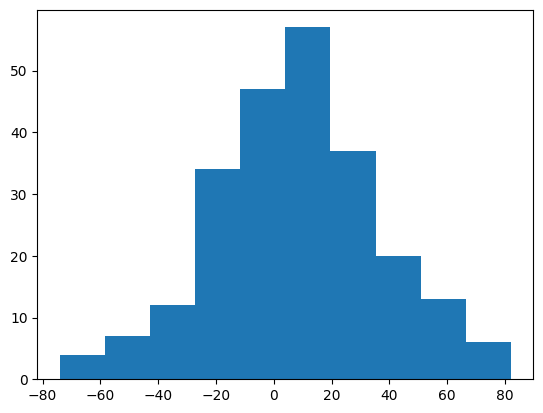

In [33]:
plt.hist(y_test['launch_angle'])

(array([ 18.,  50., 101., 216., 402., 523., 447., 216., 126.,  29.]),
 array([-88. , -70.5, -53. , -35.5, -18. ,  -0.5,  17. ,  34.5,  52. ,
         69.5,  87. ]),
 <BarContainer object of 10 artists>)

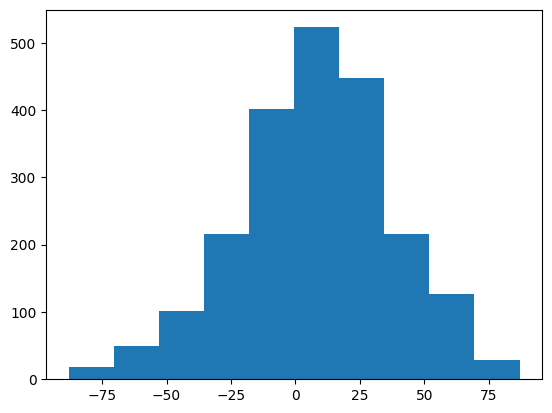

In [26]:
plt.hist(y_train['launch_angle'])

(array([8.10215193e-05, 0.00000000e+00, 0.00000000e+00, 3.24086077e-04,
        2.26860254e-03, 7.12989370e-03, 1.50700026e-02, 1.87969925e-02,
        1.63663469e-02, 1.29634431e-02, 1.32065076e-02, 1.32065076e-02,
        1.40167228e-02, 1.28824216e-02, 9.72258232e-03, 1.06138190e-02,
        1.06138190e-02, 7.53500130e-03, 4.86129116e-03, 1.05327975e-03,
        1.05327975e-03, 2.43064558e-04, 8.10215193e-05, 8.10215193e-05,
        0.00000000e+00, 1.62043039e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.10215193e-05]),
 array([ 24. ,  29.8,  35.6,  41.4,  47.2,  53. ,  58.8,  64.6,  70.4,
         76.2,  82. ,  87.8,  93.6,  99.4, 105.2, 111. , 116.8, 122.6,
        128.4, 134.2, 140. , 145.8, 151.6, 157.4, 163.2, 169. , 174.8,
        180.6, 186.4, 192.2, 198. ]),
 <BarContainer object of 30 artists>)

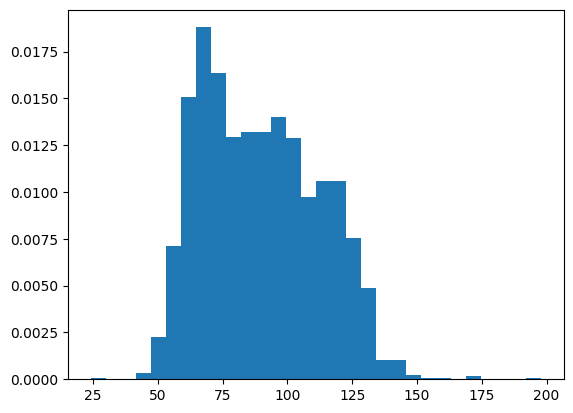

In [35]:
plt.hist(y_train['spray_angle'], bins=30, density=True)

In [20]:
import numpy as np
import scipy.stats as stats

# Given covariance matrix
cov_matrix = np.cov(y_train, rowvar=False)

# Number of samples to generate
n_samples = 1000

# Step 1: Generate correlated normal samples
normal_samples = np.random.multivariate_normal(np.zeros(3), cov_matrix, size=n_samples)

# Step 2: Transform normal samples to uniform using the normal CDF
uniform_samples = stats.norm.cdf(normal_samples)

# Define the CDFs and inverse CDFs (quantile functions) for your distributions
# For example, let's assume X1 is normal, X2 is exponential, and X3 is uniform

# Step 3: Transform uniform samples to the target distributions
# Normal Distribution (X1)
samples_X1 = stats.norm.ppf(uniform_samples[:, 0], loc=0, scale=1)

# Exponential Distribution (X2)
samples_X2 = stats.expon.ppf(uniform_samples[:, 1], scale=1)

# Uniform Distribution (X3)
samples_X3 = stats.uniform.ppf(uniform_samples[:, 2], loc=0, scale=1)

# Combine samples
correlated_samples = np.vstack((samples_X1, samples_X2, samples_X3)).T

# `correlated_samples` now contains samples from the original distributions with the specified correlation
#print(np.corrcoef(cov_matrix))
#np.corrcoef(correlated_samples,rowvar=False)
cov_matrix

array([[160.6023023 ,  58.46736363, -55.42909901],
       [ 58.46736363, 672.57435849, 240.4290056 ],
       [-55.42909901, 240.4290056 , 580.57393431]])

In [14]:
sample_data = pd.DataFrame(correlated_samples, columns = y_test.columns)

In [15]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import SingleTableMetadata
import time

test_meta = SingleTableMetadata()
test_meta.detect_from_dataframe(y_test)
# 1. perform basic validity checks
diagnostic = run_diagnostic(y_test, sample_data, test_meta)

# 2. measure the statistical similarity
quality_report = evaluate_quality(y_test, sample_data, test_meta)



for col in y_test.columns:

    # 3. plot the data
    fig = get_column_plot(
        real_data=y_test,
        synthetic_data=sample_data,
        metadata=test_meta,
        column_name=col
    )
        
    fig.show()

    time.sleep(1)

2024-05-18 11:37:28,721 - sdv.metadata.single_table - INFO - Detected metadata:
2024-05-18 11:37:28,722 - sdv.metadata.single_table - INFO - {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "launch_speed": {
            "sdtype": "numerical"
        },
        "launch_angle": {
            "sdtype": "numerical"
        },
        "spray_angle": {
            "sdtype": "numerical"
        }
    }
}


Generating report ...

(1/2) Evaluating Data Validity: |█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 690.23it/s]|
Data Validity Score: 33.33%

(2/2) Evaluating Data Structure: |████████████████████████████████████████████████████| 1/1 [00:00<00:00, 436.23it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 66.67%

Generating report ...

(1/2) Evaluating Column Shapes: |█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 514.93it/s]|
Column Shapes Score: 11.21%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.86it/s]|
Column Pair Trends Score: 96.2%

Overall Score (Average): 53.71%



In [100]:
from sklearn.linear_model import LinearRegression

# Assuming X and y are your DataFrames containing predictors and target variables respectively

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X_train, y_train)

# Print the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [[-3.94505144e+00 -8.57857808e-04  8.75270578e+00 -1.47486585e+01
   1.03546593e+01  3.64354040e-02 -1.61562908e-02 -3.05112467e+00
  -6.18757789e+00 -6.22592511e+00 -3.00907249e+00  7.99479532e-01
  -9.62734920e-01 -2.06892957e-01  9.20996029e-01  1.28219354e+01
  -2.81414809e+00]
 [ 4.92805450e+00  1.25319392e-02 -1.92122249e+01 -1.15788622e+01
  -1.82441572e+01 -1.82355074e+01 -6.85125512e-02 -1.98566114e+01
  -1.52936139e+01 -4.85790262e+00  4.51768929e+00 -6.33911305e+00
   8.43870183e-02 -7.38400435e-01  1.17767824e+00  1.95072182e+01
   3.15899474e+01]
 [ 2.96572356e+01  4.97611463e-03 -1.33418027e+01 -4.54381644e+00
  -1.39898731e+01  3.17639271e+01 -2.73275670e-04  1.28000763e+01
   1.29356766e+01 -2.38485401e+00  1.81623155e+01  1.39734318e+01
  -1.54004735e+00 -1.34089462e+00  1.55636065e+00 -4.57296563e+00
  -2.73793681e+01]]
Intercept: [-521.84820384 1319.5902992   624.55101623]


In [101]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict the target variables using the fitted model
y_pred = model.predict(X_test)

# Calculate mean squared error for each target variable
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

# Calculate R-squared (coefficient of determination) for each target variable
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print mean squared error and R-squared for each target variable
for i, (mse_i, r2_i) in enumerate(zip(mse, r2)):
    print(f"Target variable {i+1}:")
    print(f"  Mean Squared Error: {mse_i:.4f}")
    print(f"  R-squared: {r2_i:.4f}")
    print()


Target variable 1:
  Mean Squared Error: 228.2909
  R-squared: -0.0352

Target variable 2:
  Mean Squared Error: 667.4073
  R-squared: 0.2388

Target variable 3:
  Mean Squared Error: 644.5946
  R-squared: 0.0797



In [103]:
# Get the coefficients (slopes) of the linear regression model
coefficients = model.coef_

# Print the coefficients for each target variable
for i, target_variable in enumerate(y_test.columns):
    print(f"Significant variables for target variable '{target_variable}':")
    sorted_indices = np.argsort(np.abs(coefficients[i]))[::-1]  # Sort indices by absolute coefficient values
    for j, index in enumerate(sorted_indices):
        variable_name = X_test.columns[index]  # Assuming X has column names
        coefficient_value = coefficients[i][index]
        print(f"  {j+1}. {variable_name}: {coefficient_value:.4f}")
    print()


Significant variables for target variable 'launch_speed':
  1. release_pos_x: -14.7487
  2. plate_x: 12.8219
  3. release_pos_y: 10.3547
  4. release_extension: 8.7527
  5. vx0: -6.2259
  6. pfx_z: -6.1876
  7. release_speed: -3.9451
  8. pfx_x: -3.0511
  9. vy0: -3.0091
  10. plate_z: -2.8141
  11. ax: -0.9627
  12. az: 0.9210
  13. vz0: 0.7995
  14. ay: -0.2069
  15. release_pos_z: 0.0364
  16. spin_axis: -0.0162
  17. release_spin_rate: -0.0009

Significant variables for target variable 'launch_angle':
  1. plate_z: 31.5899
  2. pfx_x: -19.8566
  3. plate_x: 19.5072
  4. release_extension: -19.2122
  5. release_pos_y: -18.2442
  6. release_pos_z: -18.2355
  7. pfx_z: -15.2936
  8. release_pos_x: -11.5789
  9. vz0: -6.3391
  10. release_speed: 4.9281
  11. vx0: -4.8579
  12. vy0: 4.5177
  13. az: 1.1777
  14. ay: -0.7384
  15. ax: 0.0844
  16. spin_axis: -0.0685
  17. release_spin_rate: 0.0125

Significant variables for target variable 'spray_angle':
  1. release_pos_z: 31.7639
  2. 

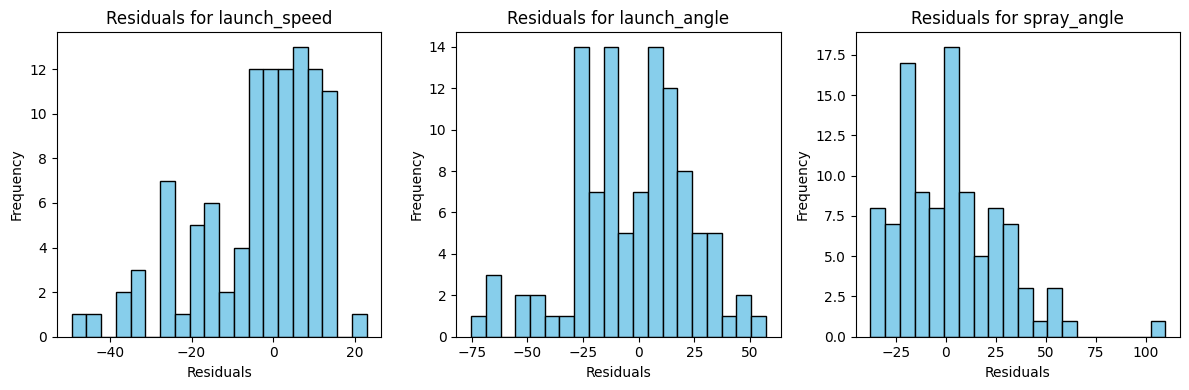

In [108]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot histograms of residuals for each target variable
plt.figure(figsize=(12, 4))
for i, column in enumerate(residuals.columns):
    plt.subplot(1, 3, i+1)
    plt.hist(residuals[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Residuals for {column}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


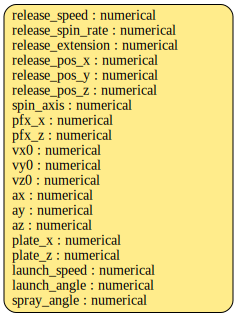

In [57]:
metadata.visualize()

In [87]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

metadata = SingleTableMetadata()

data = pd.concat([X_train, y_train], axis=1)

metadata.detect_from_dataframe(data)

synthesizer = GaussianCopulaSynthesizer(
    metadata,
    enforce_min_max_values=True,
    enforce_rounding=False,
    default_distribution='gaussian_kde'
)

synthesizer.fit(data)

synthetic_data = synthesizer.sample(num_rows=300)

2024-05-17 19:28:40,896 - sdv.metadata.single_table - INFO - Detected metadata:
2024-05-17 19:28:40,896 - sdv.metadata.single_table - INFO - {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "release_speed": {
            "sdtype": "numerical"
        },
        "release_spin_rate": {
            "sdtype": "numerical"
        },
        "release_extension": {
            "sdtype": "numerical"
        },
        "release_pos_x": {
            "sdtype": "numerical"
        },
        "release_pos_y": {
            "sdtype": "numerical"
        },
        "release_pos_z": {
            "sdtype": "numerical"
        },
        "spin_axis": {
            "sdtype": "numerical"
        },
        "pfx_x": {
            "sdtype": "numerical"
        },
        "pfx_z": {
            "sdtype": "numerical"
        },
        "vx0": {
            "sdtype": "numerical"
        },
        "vy0": {
            "sdtype": "numerical"
        },
        "vz0": {
            "sd

In [88]:
y_test_sample = synthesizer.sample_remaining_columns(
    known_columns=X_test,
    max_tries_per_batch=500
)

Sampling remaining columns:  22%|███████████▍                                        | 23/105 [00:02<00:09,  8.95it/s]2024-05-17 19:28:55,358 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,442 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,533 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,639 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,716 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,793 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,871 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:55,959 - sdv.single_table.base - INFO - 1 valid rows remaining. Resampling 1 rows
2024-05-17 19:28:56,038 - sdv.single_table.base - INFO - 1 valid rows remaining. Resamplin

In [90]:
y_samp = y_test_sample.drop(X_test.columns, axis=1)

In [96]:
print(np.corrcoef(y_samp, rowvar=False), '\n\n',np.corrcoef(y_test,rowvar=False))

[[ 1.          0.03185529 -0.2040295 ]
 [ 0.03185529  1.          0.38391351]
 [-0.2040295   0.38391351  1.        ]] 

 [[ 1.          0.14057268 -0.38321054]
 [ 0.14057268  1.          0.36117841]
 [-0.38321054  0.36117841  1.        ]]


In [97]:
y_samp.describe()

,launch_speed,launch_angle,spray_angle
count,103.000000,103.000000,103.000000
mean,86.534861,20.815534,88.591869
std,14.477677,23.088809,26.474576
min,26.845409,-41.000000,43.655933
25%,78.552767,6.000000,66.407716
50%,89.235308,22.000000,86.877697
75%,96.586132,35.500000,107.381096
max,109.669723,76.000000,184.547668


In [98]:
y_test.describe()

,launch_speed,launch_angle,spray_angle
count,105.000000,105.000000,105.000000
mean,83.852381,14.047619,88.390476
std,14.921133,29.751658,26.592182
min,40.200000,-64.000000,40.000000
25%,73.000000,-1.000000,67.000000
50%,88.400000,13.000000,86.000000
75%,94.700000,30.000000,105.000000
max,104.700000,86.000000,201.000000


In [91]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
import time
#real_data = pd.concat([X_test, y_test], axis=1) #pd.concat([X_train, y_train], axis=1)

test_meta = SingleTableMetadata()
test_meta.detect_from_dataframe(y_test)
# 1. perform basic validity checks
diagnostic = run_diagnostic(y_test, y_samp, test_meta)

# 2. measure the statistical similarity
quality_report = evaluate_quality(y_test, y_samp, test_meta)



for col in y_test.columns:

    # 3. plot the data
    fig = get_column_plot(
        real_data=real_data,
        synthetic_data=synthetic_data,
        metadata=test_meta,
        column_name=col
    )
        
    fig.show()

    time.sleep(1)

2024-05-17 19:30:56,659 - sdv.metadata.single_table - INFO - Detected metadata:
2024-05-17 19:30:56,660 - sdv.metadata.single_table - INFO - {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "launch_speed": {
            "sdtype": "numerical"
        },
        "launch_angle": {
            "sdtype": "numerical"
        },
        "spray_angle": {
            "sdtype": "numerical"
        }
    }
}


Generating report ...

(1/2) Evaluating Data Validity: |█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 709.22it/s]|
Data Validity Score: 98.38%

(2/2) Evaluating Data Structure: |████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.11it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.19%

Generating report ...

(1/2) Evaluating Column Shapes: |█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 711.26it/s]|
Column Shapes Score: 86.13%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████| 3/3 [00:00<00:00, 177.89it/s]|
Column Pair Trends Score: 94.82%

Overall Score (Average): 90.48%

